In [ ]:
# Healthcare Data Analytics - ETL Script
import pandas as pd
import re
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 1: Extract - Load the CSV
csv_file = "/content/drive/My Drive/Health Care_Patient_survey_source.csv"
data = pd.read_csv(csv_file)

# Function to extract latitude and longitude from the 'Location' column
def extract_lat_lon(location):
    match = re.search(r"\(([-\d.]+), ([-\d.]+)\)", location)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

# Step 2: Process Hospitals Table
data['latitude'], data['longitude'] = zip(*data['Location'].apply(extract_lat_lon))
hospitals = data[['Provider ID', 'Hospital Name', 'Address', 'City', 'State',
                  'ZIP Code', 'County Name', 'Phone Number', 'latitude', 'longitude']].drop_duplicates()
hospitals.columns = ['provider_id', 'hospital_name', 'address', 'city', 'state',
                     'zip_code', 'county_name', 'phone_number', 'latitude', 'longitude']

# Step 3: Process Survey Measures Table
survey_measures = data[['Measure ID', 'Question', 'Answer Description']].drop_duplicates()
survey_measures.columns = ['measure_id', 'question', 'answer_description']

# Step 4: Process Survey Responses Table
survey_responses = data[['Provider ID', 'Measure ID', 'Patient Survey Star Rating',
                         'Answer Percent', 'Number of Completed Surveys',
                         'Survey Response Rate Percent', 'Measure Start Date',
                         'Measure End Date']]

survey_responses.columns = ['provider_id', 'measure_id', 'survey_star_rating',
                            'answer_percent', 'number_of_completed_surveys',
                            'survey_response_rate_percent', 'measure_start_date',
                            'measure_end_date']

# Handle missing and inconsistent data
survey_responses['measure_start_date'] = pd.to_datetime(survey_responses['measure_start_date'], errors='coerce')
survey_responses['measure_end_date'] = pd.to_datetime(survey_responses['measure_end_date'], errors='coerce')

# Step 5: Export to CSVs
output_folder = "/content/drive/My Drive/Healthcare_ETL_Files/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save cleaned files
hospitals.to_csv(f"{output_folder}hospitals.csv", index=False)
survey_measures.to_csv(f"{output_folder}survey_measures.csv", index=False)
survey_responses.to_csv(f"{output_folder}survey_responses.csv", index=False)

print(f"Files saved to {output_folder}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-6-4ea9c8c7fdaa>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_responses['measure_start_date'] = pd.to_datetime(survey_responses['measure_start_date'], errors='coerce')
<ipython-input-6-4ea9c8c7fdaa>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_responses['measure_end_date'] = pd.to_datetime(survey_responses['measure_end_date'], errors='coerce')


Files saved to /content/drive/My Drive/Healthcare_ETL_Files/


In [ ]:
# Reload Cleaned Survey Responses
survey_responses = pd.read_csv("/content/drive/My Drive/Healthcare_ETL_Files/survey_responses.csv")

# Step 1: Handle Missing Values
# 1.1 - Handle missing 'survey_star_rating' (convert empty strings to NaN and ensure it's numeric)
survey_responses['survey_star_rating'] = pd.to_numeric(survey_responses['survey_star_rating'], errors='coerce')

# 1.2 - Handle missing 'answer_percent' (convert empty strings to NaN)
survey_responses['answer_percent'] = pd.to_numeric(survey_responses['answer_percent'], errors='coerce')

# 1.3 - Handle missing 'survey_response_rate_percent' (convert empty strings to NaN)
survey_responses['survey_response_rate_percent'] = pd.to_numeric(survey_responses['survey_response_rate_percent'], errors='coerce')

# Step 2: Data Cleaning
# 2.1 - Drop rows with missing values in essential columns (e.g., 'provider_id', 'measure_id')
essential_columns = ['provider_id', 'measure_id', 'measure_start_date', 'measure_end_date']
survey_responses = survey_responses.dropna(subset=essential_columns)

# 2.2 - Check for duplicate rows and remove them
survey_responses = survey_responses.drop_duplicates()

# 2.3 - Validate date columns and filter out invalid ranges
survey_responses['measure_start_date'] = pd.to_datetime(survey_responses['measure_start_date'], errors='coerce')
survey_responses['measure_end_date'] = pd.to_datetime(survey_responses['measure_end_date'], errors='coerce')

# Ensure that start date is earlier than end date
survey_responses = survey_responses[survey_responses['measure_start_date'] < survey_responses['measure_end_date']]

# Step 3: Validation and Join with Survey Measures
# Load the survey_measures table
survey_measures = pd.read_csv("/content/drive/My Drive/Healthcare_ETL_Files/survey_measures.csv")

# Validate that all 'measure_id' in survey_responses exist in survey_measures
missing_measures = survey_responses[~survey_responses['measure_id'].isin(survey_measures['measure_id'])]
if not missing_measures.empty:
    print("Warning: Some 'measure_id' in survey_responses do not exist in survey_measures.")
    print(missing_measures)

# Step 4: Save Cleaned Survey Responses
output_folder = "/content/drive/My Drive/Healthcare_ETL_Files/"
survey_responses.to_csv(f"{output_folder}survey_responses_final.csv", index=False)

print(f"Final cleaned survey_responses table saved to {output_folder}survey_responses_final.csv")

# Optional Exploration
print("\nSummary of Missing Values in Final Survey Responses:")
print(survey_responses.isna().sum())
print(survey_responses.info())
print(survey_responses.describe())

print("\nUnique 'survey_star_rating' Values:")
print(survey_responses['survey_star_rating'].unique())

print("\nUnique 'answer_percent' Values:")
print(survey_responses['answer_percent'].unique())


Final cleaned survey_responses table saved to /content/drive/My Drive/Healthcare_ETL_Files/survey_responses_final.csv

Summary of Missing Values in Final Survey Responses:
provider_id                         0
measure_id                          0
survey_star_rating              29038
answer_percent                  17048
number_of_completed_surveys         0
survey_response_rate_percent     4050
measure_start_date                  0
measure_end_date                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34999 entries, 0 to 34998
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   provider_id                   34999 non-null  int64         
 1   measure_id                    34999 non-null  object        
 2   survey_star_rating            5961 non-null   float64       
 3   answer_percent                17951 non-null  float64       
 4   nu

# ETL Process for Patient Survey Data

## Objective
We aim to extract, transform, and clean patient survey data to prepare it for analysis and visualization. The primary goal is to process this data to identify trends, build predictive models, and create interactive dashboards for actionable insights.

## Steps Performed

1. **Data Extraction**:
   - Loaded the raw CSV file from Google Drive containing patient survey data.
2. **Data Transformation**:
   - Extracted latitude and longitude from the `Location` column using regex.
   - Split the dataset into three tables for better organization:
     - **Hospitals Table**: Contains metadata about hospitals (e.g., provider ID, name, location, and contact info).
     - **Survey Measures Table**: Contains details about the survey questions and measures (e.g., measure ID, question, and answer description).
     - **Survey Responses Table**: Contains numerical responses to survey measures, star ratings, and completion metrics.
3. **Data Cleaning**:
  

After cleaning and initial exploration of the `survey_responses` dataset, here are the key findings:

##### 1. **Missing Values**:
- **`survey_star_rating`**:
  - Only 5,961 rows (17%) have non-null values.
  - The remaining 29,038 rows contain `NaN`, indicating that star ratings are not applicable for many measures (e.g., linear scores or specific survey questions).
- **`answer_percent`**:
  - Around 51% (17,048 rows) of the entries are missing (`NaN`).
  - Missing values here may represent measures without a percentage response metric or data that wasn’t collected.
- **`survey_response_rate_percent`**:
  - Missing in about 4,050 rows (~12%).
  - This field represents the percentage of surveys completed by patients and returned to the hospital.

##### 2. **Data Distribution**:
- **`survey_star_rating`**:
  - Ranges from `1.0` (lowest rating) to `5.0` (highest rating).
  - The average star rating is approximately **2.94**, and most hospitals fall between `2` and `4`.
- **`answer_percent`**:
  - Ranges from `0%` to `98%`, with a mean value of **34.5%**.
  - Most common values appear to cluster around `11%`, `21%`, and `63%`.
- **`survey_response_rate_percent`**:
  - Ranges from `7%` to `60%`.
  - The mean response rate is **23.8%**, with most hospitals clustering between `19%` and `28%`.

##### 3. **Data Coverage**:
- **Date Range**:
  - The dataset covers a single reporting period from **2017-07-01 to 2018-06-30**.
- **Completeness**:
  - Columns like `provider_id`, `measure_id`, and date fields are fully populated.
  - Other columns (e.g., `survey_star_rating`, `answer_percent`) have missing data depending on the type of measure.

---

# Variable Dictionary

Below is a description of key variables used in the dataset:

### **1. Hospitals Table**
| Column Name     | Description                                                                 |
|-----------------|-----------------------------------------------------------------------------|
| `provider_id`   | Unique identifier for the hospital.                                         |
| `hospital_name` | Name of the hospital.                                                      |
| `address`       | Street address of the hospital.                                            |
| `city`          | City where the hospital is located.                                        |
| `state`         | State abbreviation (e.g., CA for California).                              |
| `zip_code`      | ZIP code for the hospital location.                                        |
| `county_name`   | County where the hospital is located.                                      |
| `phone_number`  | Contact number of the hospital.                                            |
| `latitude`      | Latitude of the hospital's location (extracted from the `Location` column).|
| `longitude`     | Longitude of the hospital's location (extracted from the `Location` column).|

### **2. Survey Measures Table**
| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `measure_id`        | Unique identifier for the survey measure/question.                        |
| `question`          | Text of the survey question (e.g., "How often was the area around your room quiet at night?"). |
| `answer_description`| Description of the possible answers (e.g., "Always," "Sometimes").         |

### **3. Survey Responses Table**
| Column Name                     | Description                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| `provider_id`                   | Unique identifier for the hospital.                                         |
| `measure_id`                    | Unique identifier for the survey measure/question.                        |
| `survey_star_rating`            | Overall star rating for the hospital (1–5 stars), based on patient feedback.|
| `answer_percent`                | Percentage of respondents who gave a specific answer (e.g., "Always").      |
| `number_of_completed_surveys`   | Total number of surveys completed for the hospital.                         |
| `survey_response_rate_percent`  | Percentage of surveys sent out that were completed and returned.            |
| `measure_start_date`            | Start date for the survey's reporting period.                               |
| `measure_end_date`              | End date for the survey's reporting period.                                 |




In [ ]:
# Import necessary libraries
import pandas as pd

# Load survey_responses and hospitals tables
survey_responses = pd.read_csv("/content/drive/My Drive/Healthcare_ETL_Files/survey_responses_final.csv")
hospitals = pd.read_csv("/content/drive/My Drive/Healthcare_ETL_Files/hospitals.csv")
survey_measures = pd.read_csv("/content/drive/My Drive/Healthcare_ETL_Files/survey_measures.csv")

# Step 1: Positive Response Ratio
# Filter for favorable measures (e.g., answer_description = "Always")
favorable_measures = survey_measures[survey_measures['answer_description'].str.contains("Always", na=False)]
favorable_responses = survey_responses.merge(favorable_measures, on='measure_id', how='inner')

# Calculate the positive response ratio by hospital
positive_responses = favorable_responses.groupby('provider_id')['answer_percent'].mean().reset_index()
positive_responses.columns = ['provider_id', 'positive_response_ratio']

# Step 2: Average survey_star_rating by hospital
avg_star_rating = survey_responses.groupby('provider_id')['survey_star_rating'].mean().reset_index()
avg_star_rating.columns = ['provider_id', 'avg_survey_star_rating']

# Step 3: Geographical Analysis
# Merge survey_responses with hospitals on provider_id
geo_analysis = survey_responses.merge(hospitals, on='provider_id', how='left')

# Calculate average survey_star_rating by state, city, and county
state_avg = geo_analysis.groupby('state')['survey_star_rating'].mean().reset_index()
state_avg.columns = ['state', 'avg_star_rating_by_state']

city_avg = geo_analysis.groupby(['state', 'city'])['survey_star_rating'].mean().reset_index()
city_avg.columns = ['state', 'city', 'avg_star_rating_by_city']

county_avg = geo_analysis.groupby(['state', 'county_name'])['survey_star_rating'].mean().reset_index()
county_avg.columns = ['state', 'county_name', 'avg_star_rating_by_county']

# Step 4: Merge Features into Main Dataset
survey_responses = survey_responses.merge(avg_star_rating, on='provider_id', how='left')
survey_responses = survey_responses.merge(positive_responses, on='provider_id', how='left')

# Step 5: Save the Feature-Engineered Data
output_folder = "/content/drive/My Drive/Healthcare_ETL_Files/"
survey_responses.to_csv(f"{output_folder}survey_responses_featured.csv", index=False)

# Save Geographical Aggregates
state_avg.to_csv(f"{output_folder}state_avg_star_rating.csv", index=False)
city_avg.to_csv(f"{output_folder}city_avg_star_rating.csv", index=False)
county_avg.to_csv(f"{output_folder}county_avg_star_rating.csv", index=False)

print(f"Feature-engineered dataset and geographical aggregates saved to {output_folder}")


Feature-engineered dataset and geographical aggregates saved to /content/drive/My Drive/Healthcare_ETL_Files/
       avg_star_rating_by_county
count                 186.000000
mean                    3.224497
std                     0.650665
min                     1.454545
25%                     2.818182
50%                     3.181818
75%                     3.636364
max                     4.818182
state                         0
county_name                   0
avg_star_rating_by_county    60
dtype: int64
       avg_star_rating_by_state
count                  7.000000
mean                   3.117011
std                    0.294691
min                    2.690409
25%                    2.905415
50%                    3.172727
75%                    3.311191
max                    3.522727
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    ----------

### Project Context

This project analyzes patient satisfaction data from the **HCAHPS (Hospital Consumer Assessment of Healthcare Providers and Systems)** survey. The dataset contains responses from hospitals across the United States, focusing on two key types of questions:

1. **Rating-Based Questions**: Patients rate aspects of their experience on a 1–5 star scale (e.g., overall hospital rating).
2. **Non-Rating Questions**: Patients respond to specific aspects (e.g., cleanliness) with answers like `"Always"`, `"Usually"`, etc.

The goal is to **extract insights**, **build predictive models**, and **create actionable dashboards** to help hospitals improve patient care and operational efficiency. Key features engineered include:
- **Average Star Ratings** for rating-based questions.
- **Positive Response Ratio** for non-rating questions (e.g., percentage of patients who answered `"Always"`).
- **Geographical Aggregates** to analyze satisfaction trends across states, cities, and counties.


In [ ]:
# Import necessary libraries
import pandas as pd

# File paths
output_folder = "/content/drive/My Drive/Healthcare_ETL_Files/"
survey_responses_file = f"{output_folder}survey_responses_featured.csv"
state_avg_file = f"{output_folder}state_avg_star_rating.csv"
city_avg_file = f"{output_folder}city_avg_star_rating.csv"
county_avg_file = f"{output_folder}county_avg_star_rating.csv"

# Load the datasets
survey_responses = pd.read_csv(survey_responses_file)
state_avg = pd.read_csv(state_avg_file)
city_avg = pd.read_csv(city_avg_file)
county_avg = pd.read_csv(county_avg_file)

# Function to display dataset information and statistics
def display_table_info(table_name, table):
    print(f"--- {table_name} ---")
    print("\nBasic Info:")
    print(table.info())
    print("\nSummary Statistics:")
    print(table.describe(include='all'))
    print("\nSample Rows:")
    print(table.head())
    print("\n")

# Check the survey_responses_featured table
display_table_info("Survey Responses (Feature-Engineered)", survey_responses)

# Check the state_avg_star_rating table
display_table_info("State Average Star Ratings", state_avg)

# Check the city_avg_star_rating table
display_table_info("City Average Star Ratings", city_avg)

# Check the county_avg_star_rating table
display_table_info("County Average Star Ratings", county_avg)


--- Survey Responses (Feature-Engineered) ---

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34999 entries, 0 to 34998
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   provider_id                   34999 non-null  int64  
 1   measure_id                    34999 non-null  object 
 2   survey_star_rating            5961 non-null   float64
 3   answer_percent                17951 non-null  float64
 4   number_of_completed_surveys   34999 non-null  object 
 5   survey_response_rate_percent  30949 non-null  float64
 6   measure_start_date            34999 non-null  object 
 7   measure_end_date              34999 non-null  object 
 8   avg_survey_star_rating        27099 non-null  float64
 9   positive_response_ratio       30949 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 2.7+ MB
None

Summary Statistics:
         provider_id       measure_i


#### 1. **Survey Responses (Feature-Engineered)**
- The dataset contains **34,999 rows** and **10 columns**, with new features added:
  - **`avg_survey_star_rating`**: Average star rating by hospital. Only 27,099 rows have non-null values because some hospitals have no recorded star ratings.
  - **`positive_response_ratio`**: Represents the ratio of favorable responses ("Always") for each hospital. Calculated for 30,949 rows.
- Key statistics:
  - **`survey_star_rating`**: Ranges from 1 to 5 stars, with an average of 2.94.
  - **`positive_response_ratio`**: Mean value is 57.29%, ranging from 26% to 90%.
- Insights:
  - Some hospitals have many missing star ratings, but the `positive_response_ratio` provides a good alternative metric for satisfaction.

---

#### 2. **State Average Star Ratings**
- Aggregated star ratings across **7 states**.
- Key statistics:
  - The mean star rating across states is **3.12**, ranging from **2.69** to **3.52**.
- Insights:
  - Star ratings vary slightly across states, with some showing higher satisfaction levels than others.

---

#### 3. **City Average Star Ratings**
- Aggregated star ratings across **511 cities**, with data available for 388 cities.
- Key statistics:
  - The mean star rating across cities is **2.99**, ranging from **1.0** to **4.91**.
- Insights:
  - Certain cities show missing or incomplete star rating data, but available ratings highlight significant variations across locations.

---

#### 4. **County Average Star Ratings**
- Aggregated star ratings across **246 counties**, with data available for 186 counties.
- Key statistics:
  - The mean star rating across counties is **3.22**, ranging from **1.45** to **4.82**.
- Insights:
  - Counties with higher averages (closer to 4 or 5 stars) indicate regions with better patient satisfaction.

---

### Summary of Findings
- **Satisfaction Metrics**: Key features like `positive_response_ratio` and `avg_survey_star_rating` were successfully engineered to represent patient satisfaction at the hospital level.
- **Geographical Aggregates**: Satisfaction trends were aggregated by state, city, and county, offering insights into regional performance variations.
- **Next Steps**: Use these engineered features for predictive modeling or visualization to uncover actionable insights.


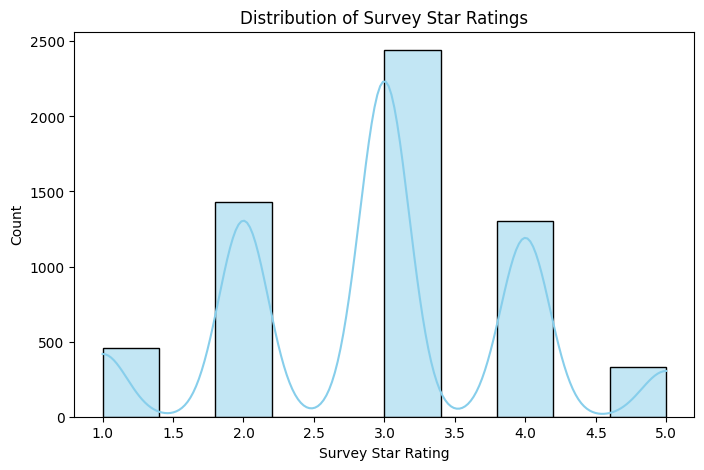

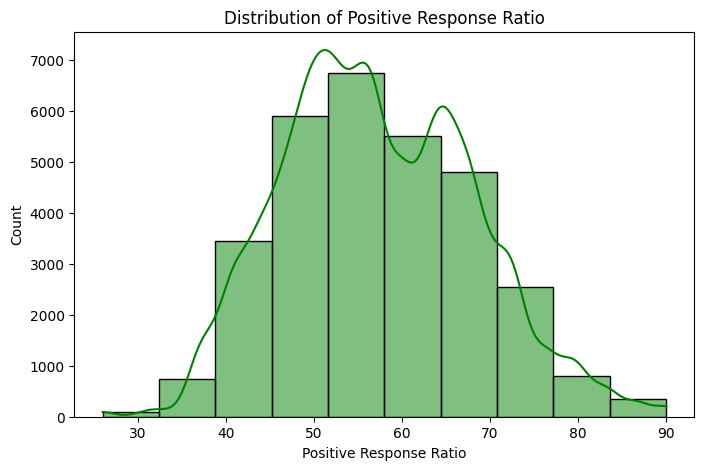

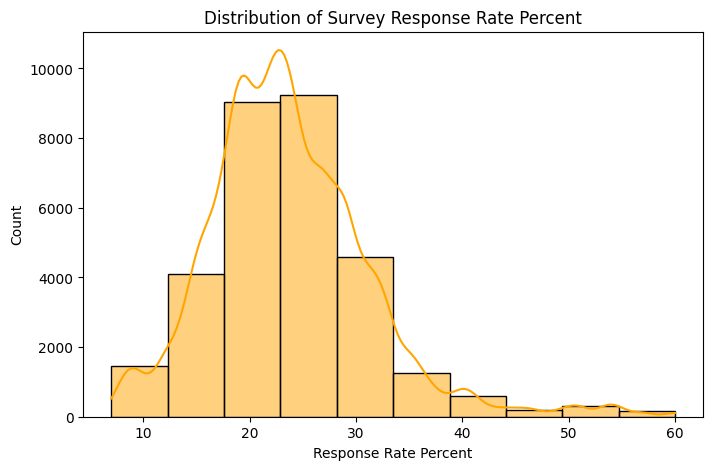


Correlation Matrix:
                               provider_id  survey_star_rating  \
provider_id                   1.000000e+00           -0.101622   
survey_star_rating           -1.016221e-01            1.000000   
answer_percent                5.014506e-15                 NaN   
survey_response_rate_percent -1.182780e-01            0.458072   
avg_survey_star_rating       -1.281928e-01            0.790765   
positive_response_ratio      -3.920654e-01            0.566728   

                              answer_percent  survey_response_rate_percent  \
provider_id                     5.014506e-15                 -1.182780e-01   
survey_star_rating                       NaN                  4.580715e-01   
answer_percent                  1.000000e+00                 -4.088899e-16   
survey_response_rate_percent   -4.088899e-16                  1.000000e+00   
avg_survey_star_rating         -7.284068e-16                  5.793263e-01   
positive_response_ratio        -1.452845e-15    

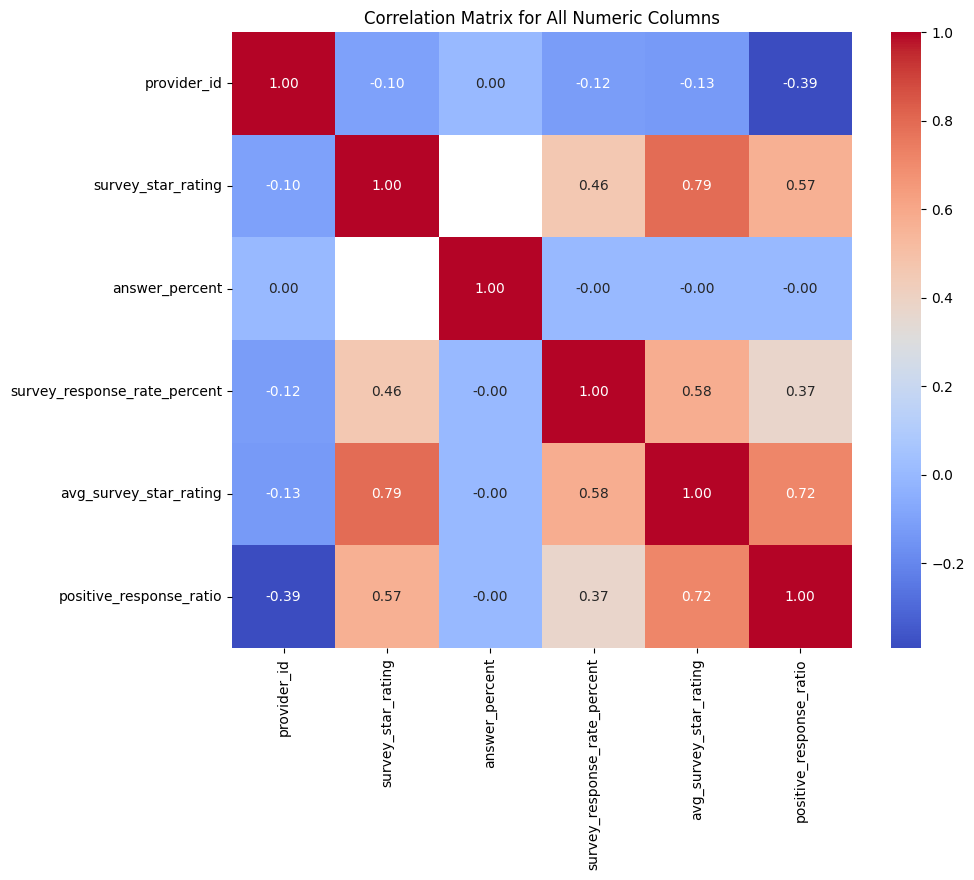

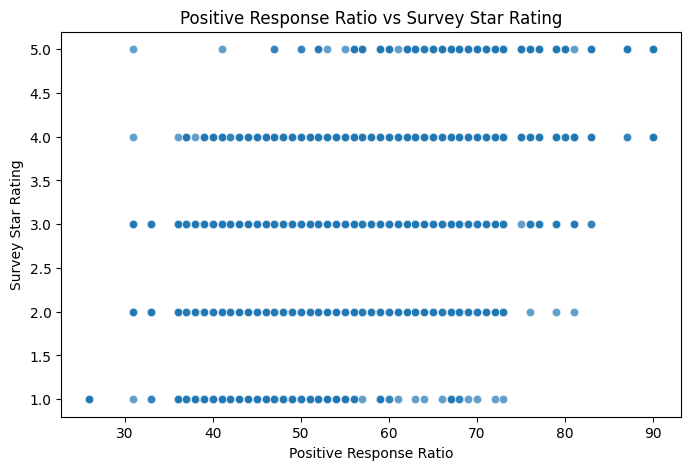

<ipython-input-19-111ad0e2b523>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='avg_star_rating_by_state', data=state_avg, palette='viridis')


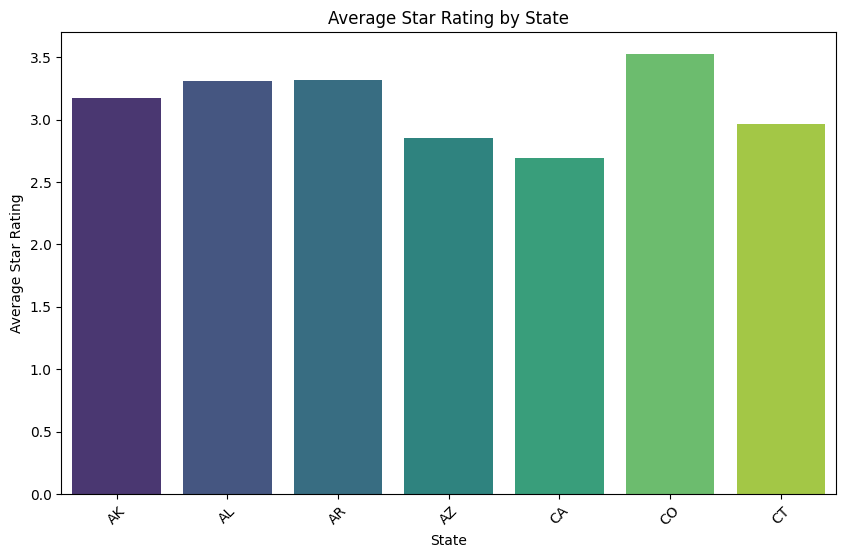


Missing Data Summary:
provider_id                         0
measure_id                          0
survey_star_rating              29038
answer_percent                  17048
number_of_completed_surveys         0
survey_response_rate_percent     4050
measure_start_date                  0
measure_end_date                    0
avg_survey_star_rating           7900
positive_response_ratio          4050
dtype: int64


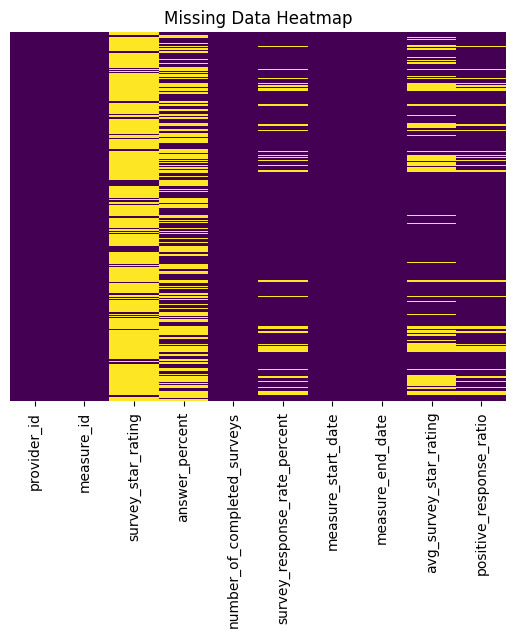

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the feature-engineered dataset
file_path = "/content/drive/My Drive/Healthcare_ETL_Files/survey_responses_featured.csv"
survey_responses = pd.read_csv(file_path)

# Step 1: Distribution of Key Variables
plt.figure(figsize=(8, 5))
sns.histplot(survey_responses['survey_star_rating'], bins=10, kde=True, color='skyblue')
plt.title("Distribution of Survey Star Ratings")
plt.xlabel("Survey Star Rating")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(survey_responses['positive_response_ratio'], bins=10, kde=True, color='green')
plt.title("Distribution of Positive Response Ratio")
plt.xlabel("Positive Response Ratio")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(survey_responses['survey_response_rate_percent'], bins=10, kde=True, color='orange')
plt.title("Distribution of Survey Response Rate Percent")
plt.xlabel("Response Rate Percent")
plt.ylabel("Count")
plt.show()

# Step 2: Correlation Between All Numeric Columns
# Select only numeric columns for correlation
numeric_columns = survey_responses.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = survey_responses[numeric_columns].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix for All Numeric Columns")
plt.show()

# Step 3: Relationship Between Positive Response Ratio and Star Rating
plt.figure(figsize=(8, 5))
sns.scatterplot(x='positive_response_ratio', y='survey_star_rating', data=survey_responses, alpha=0.7)
plt.title("Positive Response Ratio vs Survey Star Rating")
plt.xlabel("Positive Response Ratio")
plt.ylabel("Survey Star Rating")
plt.show()

# Step 4: Geographical Trends - State Level
state_avg_file = "/content/drive/My Drive/Healthcare_ETL_Files/state_avg_star_rating.csv"
state_avg = pd.read_csv(state_avg_file)

plt.figure(figsize=(10, 6))
sns.barplot(x='state', y='avg_star_rating_by_state', data=state_avg, palette='viridis')
plt.title("Average Star Rating by State")
plt.xlabel("State")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)
plt.show()

# Step 5: Missing Data Analysis
missing_data = survey_responses.isna().sum()
print("\nMissing Data Summary:")
print(missing_data)

sns.heatmap(survey_responses.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()


### EDA Interpretation and Key Insights

#### 1. **Distribution of Key Variables**
- **Survey Star Ratings**:
  - The distribution is multimodal, with peaks around 2, 3, and 4 stars.
  - Very few hospitals have extreme ratings (1 or 5 stars), suggesting most hospitals perform within a moderate range of satisfaction.
- **Positive Response Ratio**:
  - The distribution is approximately normal, with most hospitals scoring between **40% and 70%**, and the mean around **57.3%**.
  - Higher positive response ratios are strongly tied to higher satisfaction ratings.
- **Survey Response Rate Percent**:
  - The response rate is skewed toward lower values, with most hospitals achieving rates between **20% and 30%**.
  - Hospitals with higher response rates may have more reliable feedback and potentially better satisfaction scores.

---

#### 2. **Correlation Matrix**
- **Key Relationships**:
  - **`survey_star_rating` and `positive_response_ratio`**: Strong positive correlation (**0.57**), indicating favorable responses align with higher satisfaction.
  - **`survey_star_rating` and `avg_survey_star_rating`**: Very strong correlation (**0.79**), as these metrics are closely related.
  - **`positive_response_ratio` and `avg_survey_star_rating`**: Strong correlation (**0.72**), showing consistency between these two satisfaction indicators.
  - **`survey_response_rate_percent` and satisfaction metrics**:
    - Moderate correlation with `survey_star_rating` (**0.46**), suggesting response rates have some influence on satisfaction but are not primary drivers.
- **Note**: `positive_response_ratio`, `avg_survey_star_rating`, and `survey_response_rate_percent` are highly correlated and reflect similar aspects of satisfaction. This will be important to consider during predictive modeling to avoid redundancy.

---

#### 3. **Scatterplot: Positive Response Ratio vs. Survey Star Rating**
- There is a clear upward trend: hospitals with higher positive response ratios tend to have higher star ratings.
- However, the relationship is not perfectly linear, as other factors (e.g., operational metrics, geographical differences) might also play a role.

---

#### 4. **Geographical Trends**
- **State-Level Ratings**:
  - States like **CO** show noticeably higher average ratings compared to states like **CA** and **AZ**.
  - The average ratings across states range from **~2.7 to ~3.5**, suggesting room for improvement in certain regions.
- **Actionable Insight**:
  - States with lower ratings might benefit from targeted interventions.
  - High-performing states can serve as benchmarks for best practices.

---

#### 5. **Missing Data**
- **Summary**:
  - **`survey_star_rating`**: ~83% missing, reflecting measures/questions that don’t use star ratings.
  - **`answer_percent`**: ~49% missing, likely tied to measures without percentage-based responses.
  - **`survey_response_rate_percent`** and **`positive_response_ratio`**: ~12% missing, due to incomplete hospital or measure data.
  - **`avg_survey_star_rating`**: ~23% missing, reflecting hospitals with no aggregated star ratings.
- **what we are going to do next:**:
  - Focus on rows where the target (`survey_star_rating`) and its predictors (`positive_response_ratio`, `avg_survey_star_rating`, `survey_response_rate_percent`) are available.
  - we shoild avoid imputing star ratings but consider imputing response-related metrics if critical for modeling.



In [ ]:

# Load the feature-engineered dataset
file_path = "/content/drive/My Drive/Healthcare_ETL_Files/survey_responses_featured.csv"
survey_responses = pd.read_csv(file_path)

# Step 1: Drop rows where the target (survey_star_rating) is missing
survey_responses_cleaned = survey_responses.dropna(subset=['survey_star_rating'])

# Step 2: Impute missing values for key predictors using median
for col in ['positive_response_ratio', 'survey_response_rate_percent', 'avg_survey_star_rating']:
    median_value = survey_responses_cleaned[col].median()
    survey_responses_cleaned[col].fillna(median_value, inplace=True)

# Step 3: Verify missing data handling
print("Remaining Missing Values:")
print(survey_responses_cleaned.isna().sum())
print(survey_responses_cleaned.info())

# Step 4: Save the cleaned dataset
output_path = "/content/drive/My Drive/Healthcare_ETL_Files/survey_responses_cleaned.csv"
survey_responses_cleaned.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to {output_path}")


Remaining Missing Values:
provider_id                        0
measure_id                         0
survey_star_rating                 0
answer_percent                  5961
number_of_completed_surveys        0
survey_response_rate_percent       0
measure_start_date                 0
measure_end_date                   0
avg_survey_star_rating             0
positive_response_ratio            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 5961 entries, 4 to 34998
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   provider_id                   5961 non-null   int64  
 1   measure_id                    5961 non-null   object 
 2   survey_star_rating            5961 non-null   float64
 3   answer_percent                0 non-null      float64
 4   number_of_completed_surveys   5961 non-null   object 
 5   survey_response_rate_percent  5961 non-null   float64
 6   measure_sta

<ipython-input-22-9eedcfcbc52f>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survey_responses_cleaned[col].fillna(median_value, inplace=True)
<ipython-input-22-9eedcfcbc52f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_responses_cleaned[col].fillna(median_value, inplace=True)


###  Dropping Rows with Missing Survey Star Ratings

For the purposes of predictive modeling, we’ve decided to drop rows where the target variable, `survey_star_rating`, is missing. Here’s why:
- **Consistency**: Retaining only rows with valid `survey_star_rating` ensures that we’re working with a consistent and interpretable target variable for modeling.
- **Focus**: Predictive modeling focuses on satisfaction scores (star ratings). Non-rating rows don’t contribute directly to this analysis.
- **Correlation**: Key predictors like `positive_response_ratio` are highly correlated with `survey_star_rating` (correlation = 0.57). This ensures that the remaining data still provides sufficient context for modeling.

As a result, the dataset is reduced to **5,961 rows**, but this subset retains the most relevant information for analyzing patient satisfaction.


In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Load the cleaned dataset
file_path = "/content/drive/My Drive/Healthcare_ETL_Files/survey_responses_cleaned.csv"
survey_responses = pd.read_csv(file_path)

# Step 1: Define Features (Excluding `avg_survey_star_rating`) and Target
X = survey_responses[['positive_response_ratio', 'survey_response_rate_percent']]
y = survey_responses['survey_star_rating']

# Step 2: Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict on Test Data
y_pred = model.predict(X_test)

# Step 5: Evaluate Model Performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance (Excluding `avg_survey_star_rating`):")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 6: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Model Performance (Excluding `avg_survey_star_rating`):
RMSE: 0.71
R² Score: 0.49

Feature Importance:
                        Feature  Importance
0       positive_response_ratio     0.68255
1  survey_response_rate_percent     0.31745


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Step 1: Add Geographical Features (State Averages)
state_avg_path = "/content/drive/My Drive/Healthcare_ETL_Files/state_avg_star_rating.csv"
state_avg = pd.read_csv(state_avg_path)

# Step 1a: Load the provider-state mapping from hospitals.csv
provider_state_mapping_path = "/content/drive/My Drive/Healthcare_ETL_Files/hospitals.csv"
provider_state_mapping = pd.read_csv(provider_state_mapping_path)

# Step 1b: Select only the necessary columns for mapping
provider_state_mapping = provider_state_mapping[['provider_id', 'state']]

# Step 1c: Merge the mapping to add 'state' to survey_responses
survey_responses = survey_responses.merge(provider_state_mapping, on='provider_id', how='left')

# Step 1d: Merge state-level averages based on 'state'
survey_responses = survey_responses.merge(state_avg, on='state', how='left')


# Step 2: Add Interaction Terms
survey_responses['response_ratio_interaction'] = (
    survey_responses['positive_response_ratio'] * survey_responses['survey_response_rate_percent']
)

# Step 3: Define Features (Including New Features) and Target
X = survey_responses[['positive_response_ratio', 'survey_response_rate_percent',
                      'response_ratio_interaction', 'avg_star_rating_by_state']]
y = survey_responses['survey_star_rating']

# Step 4: Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Predict on Test Data
y_pred = model.predict(X_test)

# Step 7: Evaluate Model Performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance (With Additional Features):")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 8: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Model Performance (With Additional Features):
RMSE: 0.68
R² Score: 0.52

Feature Importance:
                        Feature  Importance
0       positive_response_ratio    0.505442
2    response_ratio_interaction    0.357410
1  survey_response_rate_percent    0.079825
3      avg_star_rating_by_state    0.057323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model Performance:
RMSE: 0.71
R² Score: 0.49

Feature Importance:
                        Feature  Importance
0       positive_response_ratio     0.68255
1  survey_response_rate_percent     0.31745


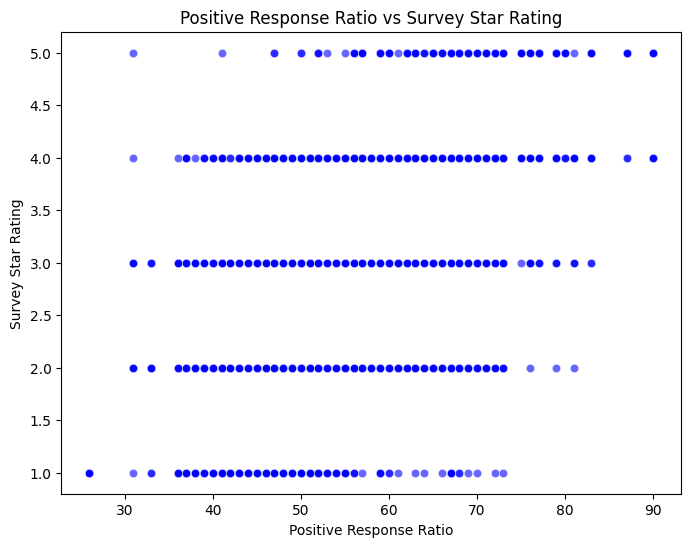

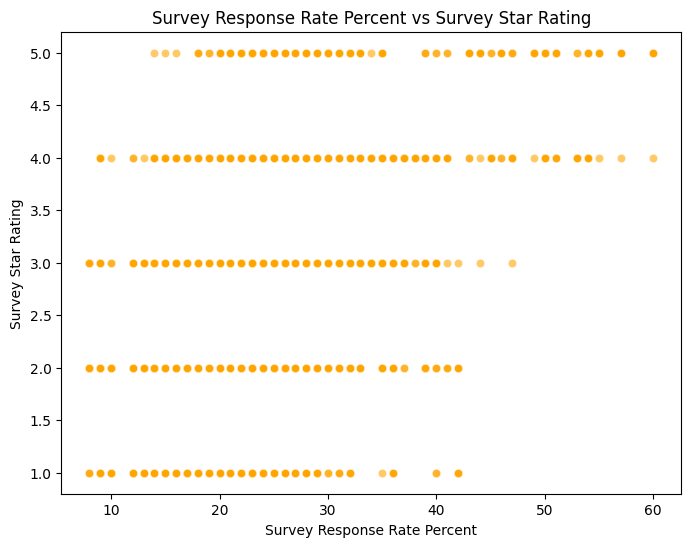

<ipython-input-36-34447138fd61>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


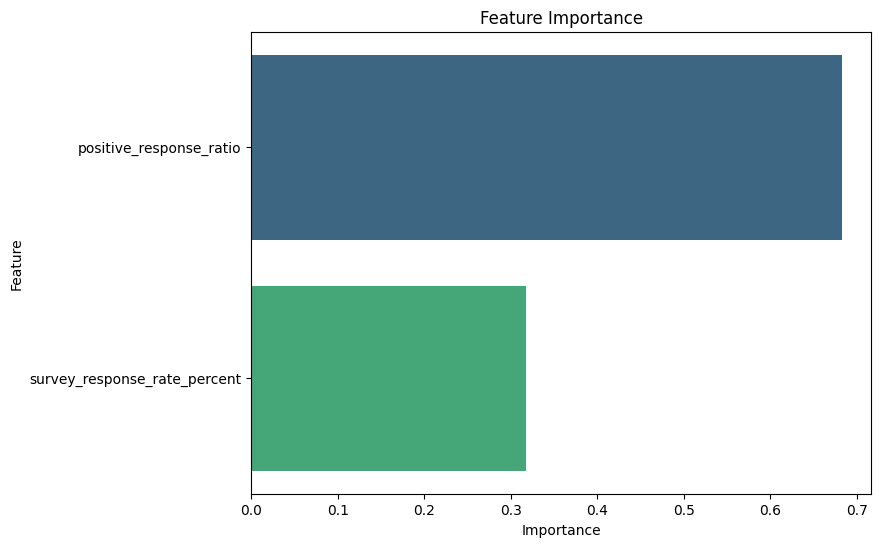

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
file_path = "/content/drive/My Drive/Healthcare_ETL_Files/survey_responses_cleaned.csv"
survey_responses = pd.read_csv(file_path)

# Define Features (Excluding `avg_survey_star_rating`) and Target
X = survey_responses[['positive_response_ratio', 'survey_response_rate_percent']]
y = survey_responses['survey_star_rating']

# Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and Evaluate Model
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Step 1: Positive Response Ratio vs. Satisfaction
plt.figure(figsize=(8, 6))
sns.scatterplot(x=survey_responses['positive_response_ratio'],
                y=survey_responses['survey_star_rating'], alpha=0.6, color='blue')
plt.title("Positive Response Ratio vs Survey Star Rating")
plt.xlabel("Positive Response Ratio")
plt.ylabel("Survey Star Rating")
plt.show()

# Step 2: Marginal Impact of Survey Response Rate
plt.figure(figsize=(8, 6))
sns.scatterplot(x=survey_responses['survey_response_rate_percent'],
                y=survey_responses['survey_star_rating'], alpha=0.6, color='orange')
plt.title("Survey Response Rate Percent vs Survey Star Rating")
plt.xlabel("Survey Response Rate Percent")
plt.ylabel("Survey Star Rating")
plt.show()

# Step 3: Feature Importance Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


### some insights so far:

1. **Feature Importance**:
   - **`positive_response_ratio` (68.3%)** is the dominant driver of `survey_star_rating`. This emphasizes the importance of patient feedback in determining satisfaction. Hospitals with higher proportions of positive responses ("Always" ratings) are more likely to achieve higher satisfaction scores.
   - **`survey_response_rate_percent` (31.7%)** plays a secondary role, indicating that hospitals with higher engagement (more survey responses) tend to have slightly better satisfaction ratings.

2. **Positive Response Ratio vs. Survey Star Rating**:
   - The scatterplot shows a clear positive trend: as the **positive response ratio** increases, satisfaction ratings (star ratings) also increase.
   - This reinforces that improving patient experiences (leading to more positive feedback) is critical to improving satisfaction scores.

3. **Survey Response Rate Percent vs. Survey Star Rating**:
   - The scatterplot reveals a weaker relationship compared to `positive_response_ratio`. While higher response rates are slightly associated with better satisfaction, the effect is less pronounced.
   - Hospitals should still aim to increase response rates for more reliable and representative feedback but prioritize improving patient experiences first.

4. **Takeaway**:
   - Focusing on **positive patient feedback** is key to improving hospital satisfaction scores.
   - While **survey engagement** (response rates) matters, its impact is secondary and should complement efforts to improve the overall patient experience.



<ipython-input-45-43d870d14530>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survey_responses['state_avg_star_rating'].fillna(mean_state_avg, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-45-43d870d14530>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated an

Improved Model Performance:
RMSE: 0.68
R² Score: 0.53

Feature Importance:
                        Feature  Importance
0       positive_response_ratio    0.440416
2    response_ratio_interaction    0.273558
3         state_avg_star_rating    0.154689
1  survey_response_rate_percent    0.131336


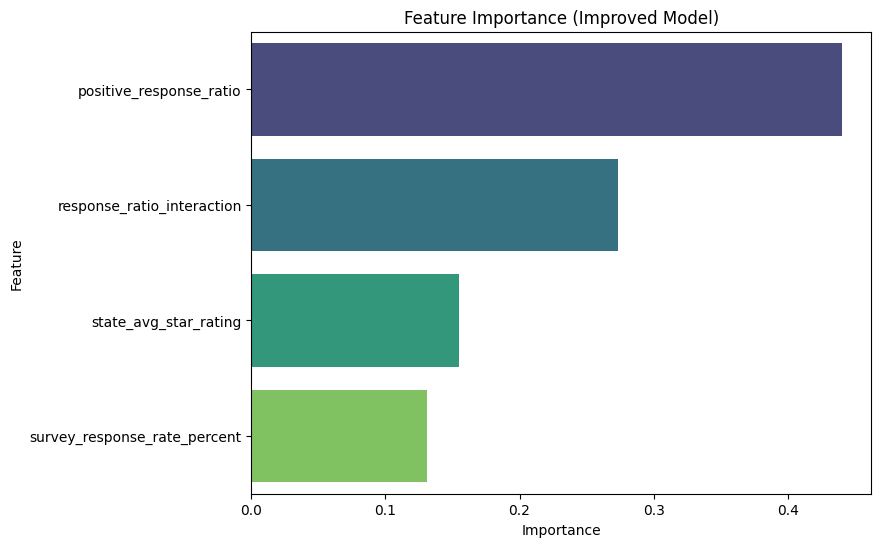

In [ ]:
# Step 1: Rename Columns for Clarity in `state_avg`
state_avg.rename(columns={'avg_star_rating_by_state': 'state_avg_star_rating'}, inplace=True)

# Step 2: Merge provider-state mapping from hospitals.csv to get state information for survey_responses
provider_state_mapping_path = "/content/drive/My Drive/Healthcare_ETL_Files/hospitals.csv"
provider_state_mapping = pd.read_csv(provider_state_mapping_path)
provider_state_mapping = provider_state_mapping[['provider_id', 'state']]  # Select necessary columns
survey_responses = survey_responses.merge(provider_state_mapping, on='provider_id', how='left') # Add 'state' column to survey_responses

# Step 3: Merge survey_responses with state_avg using 'state'
survey_responses = survey_responses.merge(state_avg, on='state', how='left')  # Merge based on 'state'

# Step 4: Drop Duplicates and Keep Relevant Columns
# survey_responses.drop(columns=['state_x', 'state_y'], inplace=True)  # If duplicate 'state' columns are created, adjust drop columns to remove the uneeded.
# Instead of dropping, let's rename columns for clarity:
survey_responses.rename(columns={'state': 'provider_state'}, inplace=True) # Original state column

# Step 5: Impute Missing Values for `state_avg_star_rating` (if needed)
mean_state_avg = survey_responses['state_avg_star_rating'].mean()
survey_responses['state_avg_star_rating'].fillna(mean_state_avg, inplace=True)

# ... (rest of your code - feature engineering, model training, etc.)
# Step 5: Feature Engineering - Add Interaction Term
survey_responses['response_ratio_interaction'] = (
    survey_responses['positive_response_ratio'] * survey_responses['survey_response_rate_percent']
)

# Step 6: Define Features and Target
X = survey_responses[['positive_response_ratio', 'survey_response_rate_percent',
                      'response_ratio_interaction', 'state_avg_star_rating']]
y = survey_responses['survey_star_rating']

# Step 7: Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train the Model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Step 9: Evaluate the Model
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Improved Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 10: Feature Importance
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize Feature Importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance (Improved Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


### **Insights from Improved Predictive Model**

The improved predictive model, which incorporates additional features and interaction terms, provides a more detailed understanding of patient satisfaction (`survey_star_rating`) and its key drivers.

#### **Model Performance**
- **RMSE (0.68)**:
  - The model’s predictions deviate by an average of **0.68 stars**, showing improved accuracy compared to previous models.
- **R² Score (0.53)**:
  - The model explains **53% of the variability** in satisfaction scores, an improvement over earlier models (R²: 0.49).

#### **Key Features and Insights**
| **Feature**                  | **Importance** | **Interpretation**                                                                 |
|------------------------------|----------------|-----------------------------------------------------------------------------------|
| `positive_response_ratio`     | **44.0%**      | The most significant predictor, highlighting the importance of **positive patient feedback**. |
| `response_ratio_interaction`  | **27.4%**      | The combined effect of **positive feedback** and **engagement** amplifies satisfaction. |
| `state_avg_star_rating`       | **15.5%**      | Adds geographical context, showing regional differences in satisfaction.          |
| `survey_response_rate_percent`| **13.1%**      | A secondary contributor, showing a modest link between survey engagement and satisfaction. |

#### **Takeaways**
1. **Positive Feedback Drives Satisfaction**:
   - Improving the **positive response ratio** (e.g., "Always" ratings) is the most effective way to increase satisfaction scores.
2. **Engagement Amplifies Feedback**:
   - Hospitals with higher survey response rates see an amplified impact of positive feedback, emphasizing the need to both engage patients and improve their experiences.
3. **Geographical Trends Are Relevant**:
   - Regional differences in satisfaction, captured through `state_avg_star_rating`, provide valuable insights for benchmarking hospital performance.

#### **Next Steps**
To translate these findings into a **dashboard** using Tableau to visualize model results, key metrics, and trends.


In [ ]:
# Step 1: Load the necessary datasets
survey_responses = pd.read_csv("/content/drive/My Drive/Healthcare_ETL_Files/survey_responses_cleaned.csv")
state_avg = pd.read_csv("/content/drive/My Drive/Healthcare_ETL_Files/state_avg_star_rating.csv")
provider_state_mapping = pd.read_csv("/content/drive/My Drive/Healthcare_ETL_Files/hospitals.csv")

# Step 2: Rename Columns for Clarity in `state_avg`
state_avg.rename(columns={'avg_star_rating_by_state': 'state_avg_star_rating'}, inplace=True)

# Step 3: Merge `provider_state_mapping` to get state information for `survey_responses`
provider_state_mapping = provider_state_mapping[['provider_id', 'state']]  # Select necessary columns
survey_responses = survey_responses.merge(provider_state_mapping, on='provider_id', how='left')  # Add 'state' column

# Step 4: Merge `survey_responses` with `state_avg` on `state`
survey_responses = survey_responses.merge(state_avg, on='state', how='left')  # Merge based on 'state'

# Step 5: Rename and Clean Columns
# Rename columns for clarity
survey_responses.rename(columns={'state': 'provider_state'}, inplace=True)

# Step 6: Impute Missing Values for `state_avg_star_rating`
mean_state_avg = survey_responses['state_avg_star_rating'].mean()
survey_responses['state_avg_star_rating'].fillna(mean_state_avg, inplace=True)

# Step 7: Feature Engineering - Add Interaction Term
survey_responses['response_ratio_interaction'] = (
    survey_responses['positive_response_ratio'] * survey_responses['survey_response_rate_percent']
)

# Step 8: Drop any unnecessary or redundant columns (if applicable)
# For example: Drop duplicate or unrelated columns if any exist
# survey_responses.drop(columns=['unnecessary_column'], inplace=True)

# Step 9: Export the Final Cleaned Dataset
output_path = "/content/drive/My Drive/Healthcare_ETL_Files/Final_cleaned_survey_responses.csv"
survey_responses.to_csv(output_path, index=False)

print(f"Final cleaned dataset saved to: {output_path}")


Final cleaned dataset saved to: /content/drive/My Drive/Healthcare_ETL_Files/Final_cleaned_survey_responses.csv


<ipython-input-47-196ce9c0d6a2>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survey_responses['state_avg_star_rating'].fillna(mean_state_avg, inplace=True)


## Final_cleaned_survey_responses.csv is being used for Tableau Dashboards!